In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from cpsrl.models.mean import ConstantMean, LinearMean
from cpsrl.models.covariance import EQ
from cpsrl.models.gp import VFEGP
from cpsrl.models.gp import VFEGPStack

In [2]:
# Check constant mean works
constant_mean = ConstantMean(input_dim=3,
                             trainable=True,
                             dtype=tf.float64)

ones = tf.ones(shape=(2, 3), dtype=tf.float64)
constant_mean(ones)

# Check linear mean works
linear_mean = LinearMean(input_dim=3,
                         trainable=True,
                         dtype=tf.float64)
linear_mean(ones)

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[0.],
       [0.]])>

In [4]:
# Check EQ covariance works
log_coeff = 0.
log_scales = [-1., -1.]

# Check EQ kernel works
eq = EQ(log_coeff=log_coeff,
        log_scales=log_scales,
        trainable=True,
        dtype=tf.float64)

x1 = tf.random.uniform(shape=(4, 2), dtype=tf.float64)
x2 = tf.random.uniform(shape=(3, 2), dtype=tf.float64)

eq(x1, x2)

<tf.Tensor: shape=(4, 3), dtype=float64, numpy=
array([[0.45461663, 0.75667772, 0.32748748],
       [0.16789625, 0.61026464, 0.05616347],
       [0.95165817, 0.64532824, 0.70734119],
       [0.21776285, 0.48481404, 0.16340673]])>

In [5]:
# Check VFEGP works
dtype = tf.float64
trainable_mean = True
trainable_cov = True
trainable_noise = True
trainable_inducing = True
log_coeff = -1.
log_scales = [-1., -1., -1.]
log_noise = -4.

num_data = 10
state_dim = 2
action_dim = 1
num_ind = 10

x_train = tf.random.uniform(shape=(num_data, state_dim + action_dim), 
                            dtype=dtype)
y_train = tf.random.uniform(shape=(num_data, state_dim),
                            dtype=dtype)

mean = LinearMean(input_dim=(state_dim+action_dim),
                  trainable=trainable_mean,
                  dtype=dtype)

cov = EQ(log_coeff=log_coeff,
         log_scales=log_scales,
         trainable=trainable_cov,
         dtype=dtype)

vfe_gp = VFEGP(mean=mean,
               cov=cov,
               x_train=x_train,
               y_train=y_train[:, :1],
               x_ind=None,
               num_ind=num_ind,
               trainable_inducing=trainable_inducing,
               log_noise=log_noise,
               trainable_noise=trainable_noise,
               dtype=dtype) 

vfe_gp.free_energy()

<tf.Tensor: shape=(), dtype=float64, numpy=-470.97936607681567>

In [6]:
# Check VFEGP works
dtype = tf.float64
trainable_mean = True
trainable_cov = True
trainable_noise = True
trainable_inducing = True
log_coeff = -1.
log_scales = [-1., -1., -1.]
log_noise = -4.

num_data = 10
state_dim = 2
action_dim = 1
num_ind = 10

x_train = tf.random.uniform(shape=(num_data, state_dim + action_dim), 
                            dtype=dtype)
y_train = tf.random.uniform(shape=(num_data, state_dim),
                            dtype=dtype)

means = [LinearMean(input_dim=(state_dim+action_dim),
                    trainable=trainable_mean,
                    dtype=dtype) for i in range(state_dim)]

covs = [EQ(log_coeff=log_coeff,
           log_scales=log_scales,
           trainable=trainable_cov,
           dtype=dtype) for i in range(state_dim)]

vfe_gps = [VFEGP(mean=means[i],
                 cov=covs[i],
                 x_train=x_train,
                 y_train=y_train[:, i:i+1],
                 x_ind=None,
                 num_ind=num_ind,
                 trainable_inducing=trainable_inducing,
                 log_noise=log_noise,
                 trainable_noise=trainable_noise,
                 dtype=dtype) 
           for i in range(state_dim)]

vfe_gp_stack = VFEGPStack(vfe_gps=vfe_gps,
                          dtype=dtype)

vfe_gp_stack.free_energy()

<tf.Tensor: shape=(), dtype=float64, numpy=-1210.0748822821033>

In [7]:
num_steps = 100
optimizer = tf.keras.optimizers.Adam(1e-1)

for step in range(num_steps + 1):
    
    with tf.GradientTape() as tape:
        
        tape.watch(vfe_gp_stack.trainable_variables)

        free_energy = vfe_gp_stack.free_energy()
        loss = - free_energy
        print(loss)
        
    gradients = tape.gradient(loss, vfe_gp_stack.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vfe_gp_stack.trainable_variables))

tf.Tensor(1210.0748822821033, shape=(), dtype=float64)
tf.Tensor(692.4862178437866, shape=(), dtype=float64)
tf.Tensor(416.7765177829333, shape=(), dtype=float64)
tf.Tensor(248.0064624812943, shape=(), dtype=float64)
tf.Tensor(159.84568930095722, shape=(), dtype=float64)
tf.Tensor(113.90334475689448, shape=(), dtype=float64)
tf.Tensor(85.32572133597633, shape=(), dtype=float64)
tf.Tensor(63.99701840925306, shape=(), dtype=float64)
tf.Tensor(51.081354028647155, shape=(), dtype=float64)
tf.Tensor(44.126097372778865, shape=(), dtype=float64)
tf.Tensor(39.64105267140407, shape=(), dtype=float64)
tf.Tensor(36.91506321665344, shape=(), dtype=float64)
tf.Tensor(32.541398390798335, shape=(), dtype=float64)
tf.Tensor(29.72654026663554, shape=(), dtype=float64)
tf.Tensor(29.41180951941697, shape=(), dtype=float64)
tf.Tensor(29.199762167380584, shape=(), dtype=float64)
tf.Tensor(28.324735983263963, shape=(), dtype=float64)
tf.Tensor(29.578340406310808, shape=(), dtype=float64)
tf.Tensor(28.946382

In [8]:
num_features = 100
x = tf.reshape(tf.range(15, dtype=dtype), (5, 3))

post_sample = vfe_gp_stack.sample_posterior(num_features=num_features)

In [9]:
post_sample(x, add_noise=True)

<dtype: 'float64'> float64
<dtype: 'float64'> float64


<tf.Tensor: shape=(5, 2), dtype=float64, numpy=
array([[-0.51045312, -0.06198798],
       [-0.4647949 ,  0.38561912],
       [ 0.19704099, -0.03896912],
       [-0.15327298,  0.09607156],
       [ 0.03273747,  0.21871951]])>

In [10]:
vfe_gp_stack.add_training_data(x_train=x_train,
                               y_train=y_train)

In [11]:
tf.debugging.assert_near(vfe_gp.noise, 0.01831, atol=1e-2)



tf.Tensor(114.78252421782885, shape=(), dtype=float64)
tf.Tensor(94.2427234204038, shape=(), dtype=float64)
tf.Tensor(77.59866483368164, shape=(), dtype=float64)
tf.Tensor(64.16610213210078, shape=(), dtype=float64)
tf.Tensor(53.352013015034174, shape=(), dtype=float64)
tf.Tensor(44.65404202048799, shape=(), dtype=float64)
tf.Tensor(37.65485162270215, shape=(), dtype=float64)
tf.Tensor(32.013224601398576, shape=(), dtype=float64)
tf.Tensor(27.453651523557056, shape=(), dtype=float64)
tf.Tensor(23.75574561521531, shape=(), dtype=float64)
tf.Tensor(20.74435998297896, shape=(), dtype=float64)
tf.Tensor(18.280871047081142, shape=(), dtype=float64)
tf.Tensor(16.255790885878675, shape=(), dtype=float64)
tf.Tensor(14.582681321584841, shape=(), dtype=float64)
tf.Tensor(13.193241139004792, shape=(), dtype=float64)
tf.Tensor(12.033396756096051, shape=(), dtype=float64)
tf.Tensor(11.060221910760397, shape=(), dtype=float64)
tf.Tensor(10.239526184652478, shape=(), dtype=float64)
tf.Tensor(9.543974

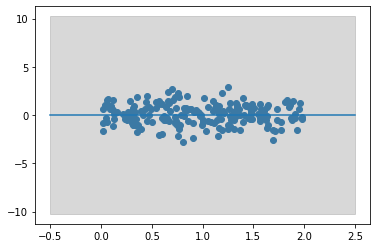

In [29]:
DTYPE = tf.float64

# Set random seed to run the same test always
tf.random.set_seed(0)

# Number of datapoints and input dimension
N = 200
D = 1

# Set all parameters to trainable
trainable_mean = False
trainable_cov = False
trainable_noise = True
trainable_inducing = False

log_coeff = -6.
log_scales = D * [2.]
log_noise = 0.
num_ind = N

# Draw random data
x_train = 2 * tf.random.uniform(shape=(N, D),
                                dtype=DTYPE)

y_train = tf.random.normal(mean=0.,
                           stddev=1.,
                           shape=(N, 1),
                           dtype=DTYPE)

# Initialise mean and covariance
mean = ConstantMean(input_dim=D,
                    trainable=trainable_mean,
                    dtype=DTYPE)

cov = EQ(log_coeff=log_coeff,
         log_scales=log_scales,
         trainable=trainable_cov,
         dtype=DTYPE)

# Initialise Variational Free Energy GP
vfe_gp = VFEGP(mean=mean,
               cov=cov,
               x_train=x_train,
               y_train=y_train,
               x_ind=None,
               num_ind=num_ind,
               trainable_inducing=trainable_inducing,
               log_noise=log_noise,
               trainable_noise=trainable_noise,
               dtype=DTYPE)

# Check optimisation works without error
num_steps = 100
optimizer = tf.keras.optimizers.Adam(1e-1)

normal = tfd.MultivariateNormalFullCovariance

for step in range(num_steps + 1):
    with tf.GradientTape() as tape:
        tape.watch(vfe_gp.trainable_variables)

        free_energy = vfe_gp.free_energy()
        loss = - free_energy

    gradients = tape.gradient(loss, vfe_gp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vfe_gp.trainable_variables)